In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
EPOCHS = 25
data_dir = "1/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [ ]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}


In [ ]:
len(dataloaders[TRAIN])

1304

In [ ]:
dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

classes = image_datasets[TRAIN].classes

class_names = image_datasets[TRAIN].classes


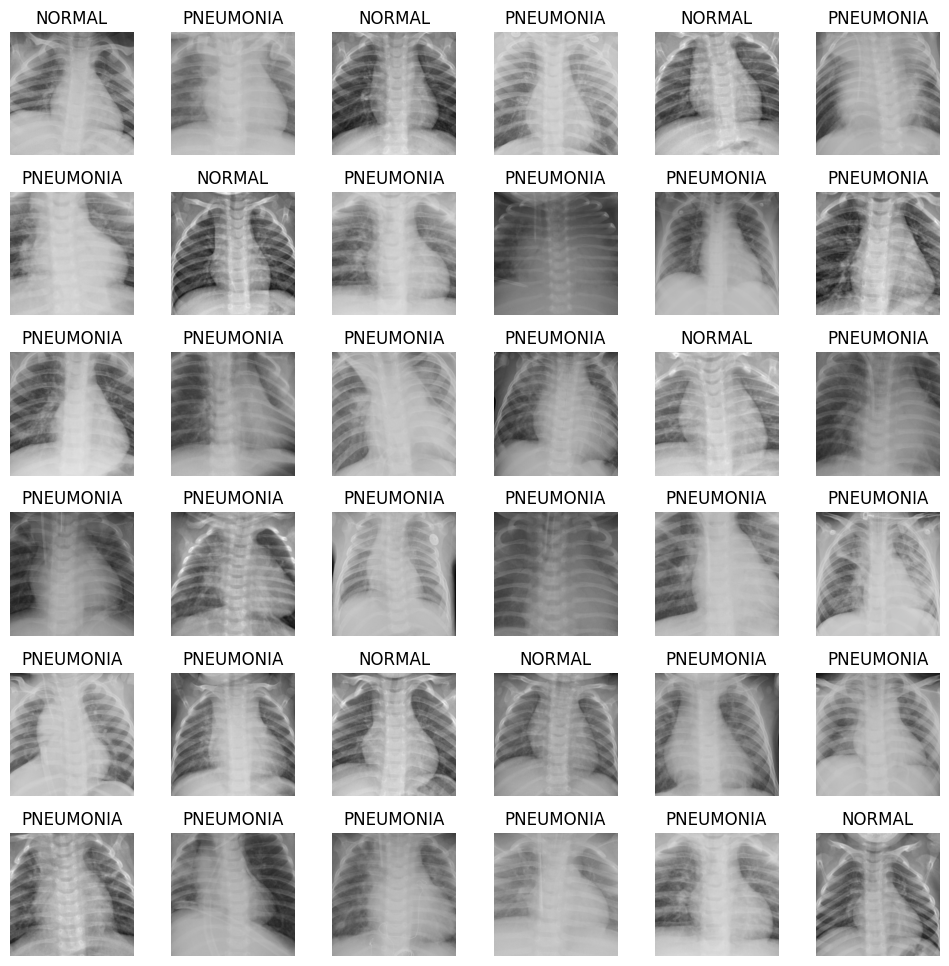

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()


In [ ]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_pre = models.vgg16()


In [ ]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/25


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.3228 Acc: 0.8690
val Loss: 1.0251 Acc: 0.6875
Epoch: 2/25
train Loss: 0.1634 Acc: 0.9425
val Loss: 0.5668 Acc: 0.8750
Epoch: 3/25
train Loss: 0.1368 Acc: 0.9484
val Loss: 1.2128 Acc: 0.6250
Epoch: 4/25
train Loss: 0.1261 Acc: 0.9528
val Loss: 1.2847 Acc: 0.6250
Epoch: 5/25
train Loss: 0.1195 Acc: 0.9566
val Loss: 0.6804 Acc: 0.7500
Epoch: 6/25
train Loss: 0.1150 Acc: 0.9572
val Loss: 1.0654 Acc: 0.6250
Epoch: 7/25
train Loss: 0.1132 Acc: 0.9584
val Loss: 1.4118 Acc: 0.6250
Epoch: 8/25
train Loss: 0.1063 Acc: 0.9576
val Loss: 0.7407 Acc: 0.7500
Epoch: 9/25
train Loss: 0.0999 Acc: 0.9609
val Loss: 0.8541 Acc: 0.6875
Epoch: 10/25
train Loss: 0.0787 Acc: 0.9685
val Loss: 0.9658 Acc: 0.6875
Epoch: 11/25
train Loss: 0.0728 Acc: 0.9739
val Loss: 0.9466 Acc: 0.7500
Epoch: 12/25
train Loss: 0.0700 Acc: 0.9739
val Loss: 0.9280 Acc: 0.6875
Epoch: 13/25
train Loss: 0.0659 Acc: 0.9760
val Loss: 1.1827 Acc: 0.6875
Epoch: 14/25
train Loss: 0.0653 Acc: 0.9777
val Loss: 1.0280 Acc: 0.8125

In [ ]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            true_labels.append(labels.item())

            input_images.append(inputs)

            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            pred_labels.append(preds.item())

            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc


In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

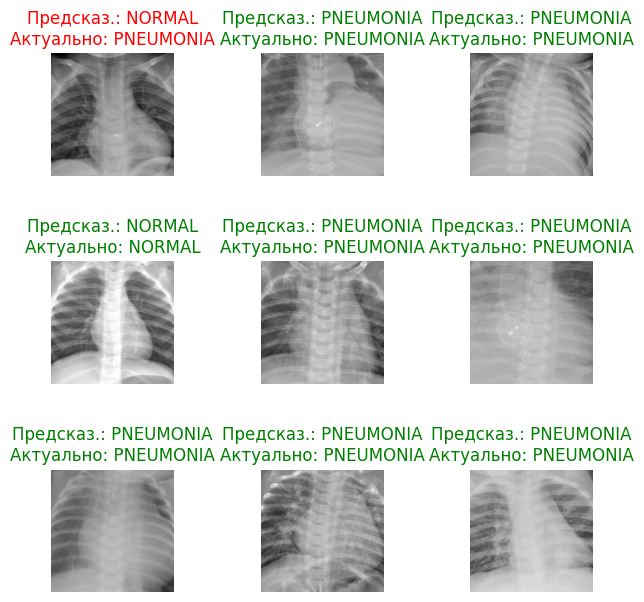

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        inp = input_images[x].squeeze()

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        axes[i, j].imshow(inp)

        title = "Предсказ.: {}\nАктуально: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        axes[i, j].axis('off')

        x += 1

plt.show()


In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)




Total Correct: 499.0 
Total Test Images: 624.0
Test Accuracy:  0.7996794871794872


In [ ]:
checkpoint = {'model': model_pre,
              'state_dict': model_pre.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')